`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `insurance` (источник: <https://www.kaggle.com/mirichoi0218/insurance/version/1>)

# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/insurance.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [3]:
# читаем таблицу из файла .csv во фрейм
fileURL = "https://raw.githubusercontent.com/ania607/ML/main/data/Carseats.csv"
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 11)


In [4]:
# первые 5 строк фрейма
DF_raw.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Здесь:  
**Sales** - продажа (в тысячах штук) в каждом магазине  
**Price** - цены компании на автокресла в каждом магазине  
**CompPrice** - цена конкурента в каждом магазине  
**ShelveLoc** - качество стеллажа для размещения автокресел в каждом магазине: Плохое, Хорошее и Среднее  

In [5]:
# типы столбцов фрейма
DF_raw.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

Проверим, нет ли в таблице пропусков.  

In [6]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

Пропусков не обнаружено.  

In [7]:
# кодируем категориальные переменные
#  пол
urban_dict = {'Yes':1,'No':0}
DF_raw['urbanYes'] = DF_raw.Urban.map(urban_dict)

#  курильщик
us_dict = {'Yes':1,'No':0}
DF_raw['ucYes'] = DF_raw.US.map(us_dict)

# находим уникальные регионы
DF_raw['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [8]:
#  добавляем фиктивные на регион: число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first=True)
df_dummy.head()

,ShelveLoc_Good,ShelveLoc_Medium
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


In [9]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(400, 15)

In [10]:
# смотрим первые 8 столбцов
DF_all.iloc[:,:8].head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age
0,9.50,138,73,11,276,120,Bad,42
1,11.22,111,48,16,260,83,Good,65
2,10.06,113,35,10,269,80,Medium,59
3,7.40,117,100,4,466,97,Medium,55
4,4.15,141,64,3,340,128,Bad,38


In [11]:
# смотрим последние 5 столбцов
DF_all.iloc[:,8:].head(5)

,Education,Urban,US,urbanYes,ucYes,ShelveLoc_Good,ShelveLoc_Medium
0,17,Yes,Yes,1,1,0,0
1,10,Yes,Yes,1,1,1,0
2,12,Yes,Yes,1,1,0,1
3,14,Yes,Yes,1,1,0,1
4,13,Yes,No,1,0,0,0


In [12]:
# оставляем в наборе данных только то, что нужно 
#  (плюс метки регионов для графиков)
DF_all = DF_all[['Sales','CompPrice','Price','ShelveLoc','ShelveLoc_Good',
                 'ShelveLoc_Medium']]

# перекодируем регион в числовой фактор, 
#  чтобы использовать на графиках
class_le = LabelEncoder()
DF_all['ShelveLoc'] = class_le.fit_transform(DF_all.ShelveLoc.values)

DF_all.columns

Index(['Sales', 'CompPrice', 'Price', 'ShelveLoc', 'ShelveLoc_Good',
       'ShelveLoc_Medium'],
      dtype='object')

In [13]:
DF_all.dtypes

Sales               float64
CompPrice             int64
Price                 int64
ShelveLoc             int32
ShelveLoc_Good        uint8
ShelveLoc_Medium      uint8
dtype: object

In [14]:
# удаляем фрейм-исходник
del DF_raw

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [15]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state = my_seed)
# данные для прогнозов
DF_predict=DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных.  

In [16]:
# описательные статистики для непрерывных переменных
DF[['Sales','CompPrice','Price']].describe()

,Sales,CompPrice,Price
count,320.000000,320.000000,320.000000
mean,7.518031,124.843750,115.168750
std,2.831121,15.313668,24.056288
min,0.000000,77.000000,24.000000
25%,5.360000,115.000000,99.000000
50%,7.475000,124.000000,117.000000
75%,9.342500,134.000000,130.000000
max,15.630000,175.000000,191.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

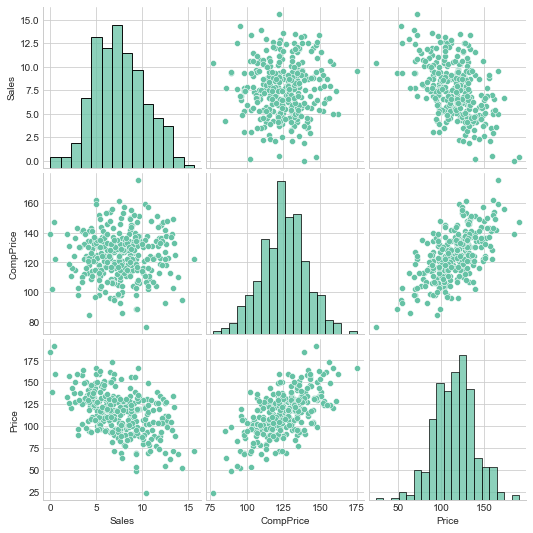

In [17]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Sales','CompPrice','Price']])
plt.show()

Судя по этим графикам:  
* можно предположить, что все данные имеют нормальное или близкое к нормальному распределение;  
* видно линейную зависимость Price и CompPrice, возможно эти переменные мультиколлинеарны и одну из них придётся убрать;
* также прослеживается зависимость Price и Sales, скорее всего будет убрана переменная CompPrice;

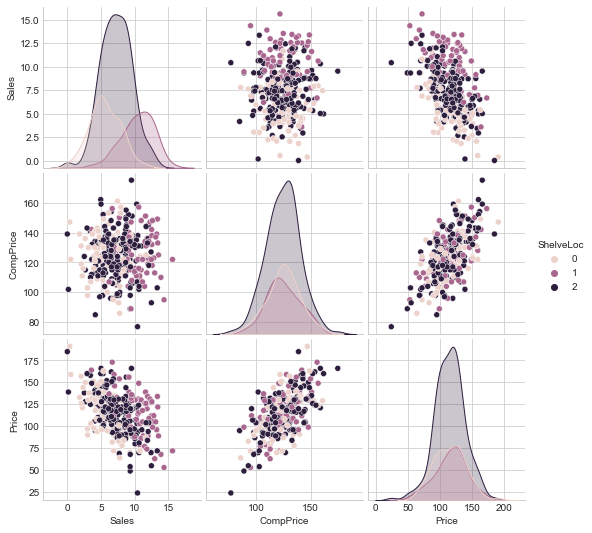

In [18]:
# матричный график разброса с цветом по полу
sns.pairplot(DF[['Sales','CompPrice','Price','ShelveLoc']],
            hue='ShelveLoc')

plt.show()

Нарисуем график отдельно по `ShelveLoc_Good `.  

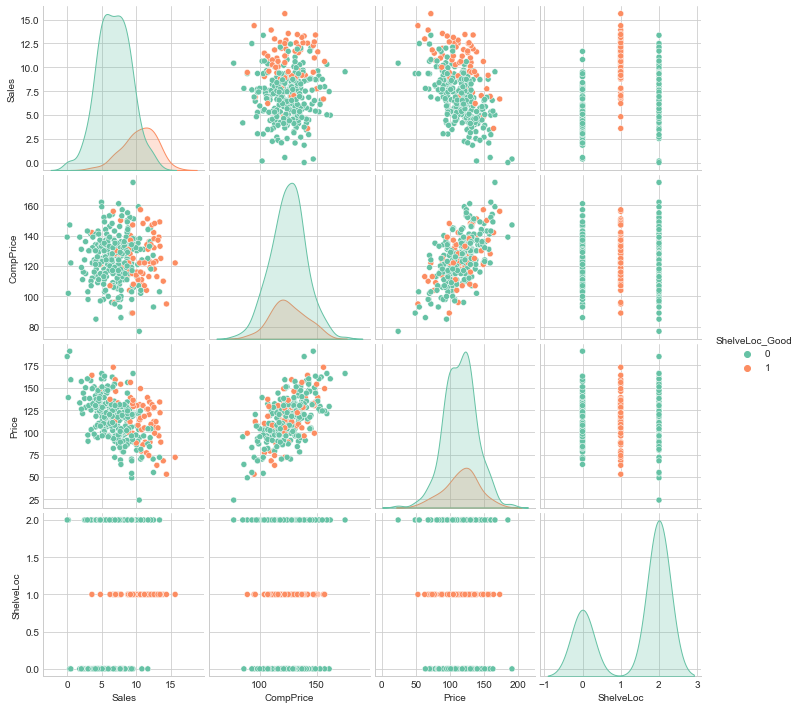

In [26]:

sns.pairplot(DF[['Sales','CompPrice','Price','ShelveLoc', 
                 'ShelveLoc_Good']], hue='ShelveLoc_Good')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [27]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Sales','CompPrice','Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\rocks\AppData\Local\Temp\ipykernel_3964\2364721642.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,Sales,CompPrice,Price
Sales,1.00,0.02,-0.46
CompPrice,0.02,1.00,0.61
Price,-0.46,0.61,1.00




### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

Проведём формальные тесты на нормальность.  

In [28]:
# тестируем на нормальность
for col in ['Sales']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Sales Statistics=0.99, p=0.2380
Распределение нормально (H0 не отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot CompPrice + \hat{\beta_2} \cdot Price + \hat{\beta_3} \cdot ShelveLoc$
1. `fit_lm_2`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Price$
1. `fit_lm_3`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Price + \hat{\beta_2} \cdot ShelveLoc$
1. `fit_lm_4`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot Price \cdot ShelveLoc$
1. `fit_lm_5`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc$


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [43]:
# данные для модели 1
df1 = DF[['Sales','CompPrice','Price','ShelveLoc']]

# данные для модели 2
df2 = DF[['Sales','Price']]

# данные для модели 3
df3 = DF[['Sales','Price','ShelveLoc']]

# данные для модели 4
df4 = DF[['Sales','Price','ShelveLoc']]
df4.loc[:, 'Price_ShelveLoc'] = df4.loc[:,'Price']*df4.loc[:,'ShelveLoc']
df4 = df4.drop(['Price','ShelveLoc'], axis=1)

# данные для модели 5
df5 = DF[['Sales','ShelveLoc']]

C:\Users\rocks\AppData\Local\Temp\ipykernel_3964\4167518548.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.loc[:, 'Price_ShelveLoc'] = df4.loc[:,'Price']*df4.loc[:,'ShelveLoc']


In [44]:
# проверка результатов
df1.head()

,Sales,CompPrice,Price,ShelveLoc
67,9.01,126,115,2
224,4.10,134,141,2
51,4.42,121,108,0
7,11.85,136,120,1
312,6.80,137,135,0


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `Sales` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [47]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)
print('модель fit_lm_1:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_1:
 константа  [6.115] 
 объясняющие  ['CompPrice', 'Price', 'ShelveLoc'] 
 коэффициенты  [[ 0.088 -0.089  0.456]]


In [48]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_1.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([2.23372041])

### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [50]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df1,df2,df3,df4,df5] :
    loo.get_n_splits(df)
    X = df.drop(['Sales'],axis=1)
    y = df.Sales
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 5.53 секунд


In [53]:
scores

[-5.105514716867489,
 -6.351629790195021,
 -6.245326297737594,
 -8.093428030671433,
 -7.944640041739478]

Определим самые точные модели отдельно на `Sales`.  

In [54]:
# самая точная на Sales
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4', 'fit_lm_5']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1 :
MSE_loocv = 5.0


Самой точной среди моделей для `Sales` оказалась `fit_lm_1`. Оценим точность прогноза по модели на отложенные наблюдения.   

In [60]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Sales']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['CompPrice','Price','ShelveLoc']]
#  прогнозы
y_pred = fit_lm_1.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_1 на отложенных наблюдениях = 4.65


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  